# Basic skeleton code for Bayesian inference

## Step 0: load all relevant modules

In [1]:
from __future__ import print_function

import subprocess

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import joblib

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from IPython.display import display, clear_output

from scipy.linalg import lapack
from scipy import stats
import emcee
import numpy as np

import os
import pickle
from pathlib import Path

import src.reader as Reader

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Step 1: prepare input files

### Load stuff from text files

In [2]:
# Read data files
RawData1       = Reader.ReadData('input/SimpleExample/Data_Selection1.dat')

# Read design points
RawDesign      = Reader.ReadDesign('input/SimpleExample/Design.dat')

# Read model prediction
RawPrediction1 = Reader.ReadPrediction('input/SimpleExample/Prediction_Selection1.dat')

### Run this block to prepare the inputs

In [3]:
# Initialize empty dictionary
AllData = {}

# Basic information
AllData["systems"] = ["PbPb5020"]
AllData["keys"] = RawDesign["Parameter"]
AllData["labels"] = RawDesign["Parameter"]
AllData["ranges"] = [(0, 1), (0, 1), (0, 1)]
AllData["observables"] = [('Y', ['C0'])]

# Data points
Data = {"PbPb5020": {"Y": {"C0": RawData1["Data"]}}}

# Model predictions
Prediction = {"PbPb5020": {"Y": {"C0": {"Y": RawPrediction1["Prediction"], "x": RawData1["Data"]['x']}}}}

# Covariance matrices - the indices are [system][measurement1][measurement2], each one is a block of matrix
Covariance = Reader.InitializeCovariance(Data)
Covariance["PbPb5020"][("Y", "C0")][("Y", "C0")] = Reader.EstimateCovariance(RawData1, RawData1, SysLength = {"default": 0.2})

# This is how we can add off-diagonal matrices
# Covariance["PbPb5020"][("R_AA", "C0")][("R_AA", "C1")] = Reader.EstimateCovariance(RawData5, RawData6, SysLength = {"default": 100}, SysStrength = {"default": 0.1})
# Covariance["PbPb5020"][("R_AA", "C1")][("R_AA", "C0")] = Reader.EstimateCovariance(RawData6, RawData5, SysLength = {"default": 100}, SysStrength = {"default": 0.1})

# This is how we can supply external pre-generated matrices
# Covariance["AuAu200"][("R_AA", "C0")][("R_AA", "C0")] = RawCov1["Matrix"]
# Covariance["AuAu200"][("R_AA", "C0")][("R_AA", "C0")] = RawCov11E["Matrix"]
# Covariance["AuAu200"][("R_AA", "C1")][("R_AA", "C1")] = RawCov22E["Matrix"]
# Covariance["PbPb2760"][("R_AA", "C0")][("R_AA", "C0")] = RawCov33E["Matrix"]
# Covariance["PbPb2760"][("R_AA", "C1")][("R_AA", "C1")] = RawCov44E["Matrix"]
# Covariance["PbPb5020"][("R_AA", "C0")][("R_AA", "C0")] = RawCov55E["Matrix"]
# Covariance["PbPb5020"][("R_AA", "C1")][("R_AA", "C1")] = RawCov66E["Matrix"]


# Assign data to the dictionary
AllData["design"] = RawDesign["Design"]
AllData["model"] = Prediction
AllData["data"] = Data
AllData["cov"] = Covariance

# Save to the desired pickle file
with open('input/default.p', 'wb') as handle:
    pickle.dump(AllData, handle, protocol = pickle.HIGHEST_PROTOCOL)

### Sanity check 1-a: plot data

### Sanity check 1-b: plot covariance matrix


### Sanity check 1-c: plot some predictions

### Optional: clean past files

In [4]:
# Clean past MCMC samples
if os.path.exists('cache/mcmc_chain.hdf'):
    os.remove("cache/mcmc_chain.hdf")

# Clean past emulator
for system in AllData["systems"]:
    if os.path.exists('cache/emulator/' + system + ".pkl"):
        os.remove('cache/emulator/' + system + ".pkl")

## Step 2: run emulator

In [5]:
! python3 -m src.emulator --retrain --npc 3 --nrestarts 50 

/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
[INFO][emulator] training emulator for system PbPb5020 (3 PC, 50 restarts)
[1 1 1]
/usr/local/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.75452039e-05, -3.74956876e+01, -1.37101481e+01, -5.97806645e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)
[INFO][emulator] writing cache file cache/emulator/PbPb5020.pkl
PbPb5020
3 PCs explain 1.00000 of variance
GP 0: 0.92461 of

In [6]:
from src import lazydict, emulator
EmulatorPbPb5020 = emulator.Emulator.from_cache('PbPb5020')

/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Step 3: MCMC sampling

In [7]:
if os.path.exists('cache/mcmc_chain.hdf'):
    os.remove("cache/mcmc_chain.hdf")
! python3 -m src.mcmc --nwalkers 100 --nburnsteps 1000 1000

/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
[INFO][mcmc] no existing chain found, starting initial burn-in
[INFO][mcmc] running 100 walkers for 500 steps
[INFO][mcmc] step 50: acceptance fraction: mean 0.4640, std 0.0797, min 0.2400, max 0.6600
[INFO][mcmc] step 100: acceptance fraction: mean 0.5460, std 0.0539, min 0.4400, max 0.7000
[INFO][mcmc] step 150: acceptance fraction: mean 0.5746, std 0.0451, min 0.4733, max 0.7133
[INFO][mcmc] step 200: acceptance fraction: mean 0.5900, std 0.0426, min 0.5000, max 0.6950
[INFO][mcmc] step 250: acceptance fraction: mean 0.5994, std 0.0356, mi

## Step 4: Load posterior samples for plotting etc

In [8]:
import src
src.Initialize()
from src import mcmc
chain = mcmc.Chain()
MCMCSamples = chain.load()

## Step 5: adding all sorts of plots

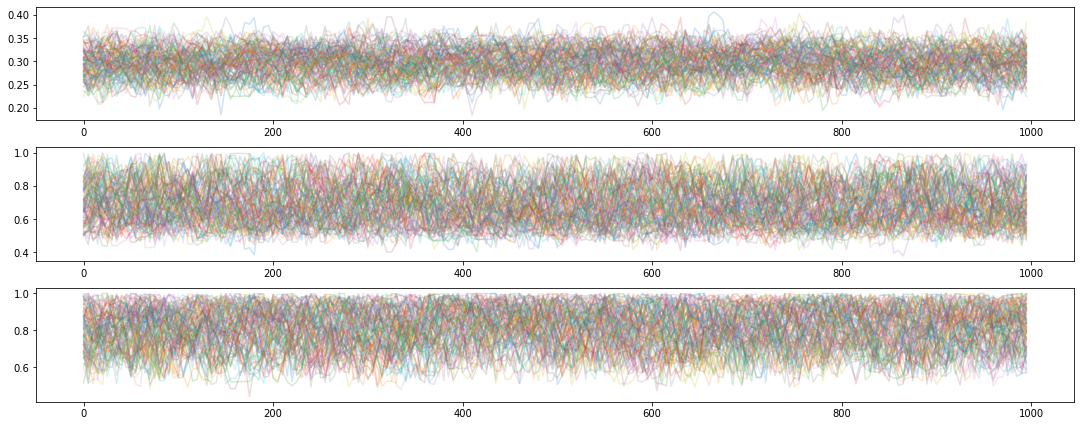

In [9]:
with chain.dataset() as d:
    W = d.shape[0]     # number of walkers
    S = d.shape[1]     # number of steps
    N = d.shape[2]     # number of paramters
    T = int(S / 200)   # "thinning"
    A = 20 / W
    figure, axes = plt.subplots(figsize = (15, 2 * N), ncols = 1, nrows = N)
    for i, ax in enumerate(axes):
        for j in range(0, W):
            ax.plot(range(0, S, T), d[j, ::T, i], alpha = A)
    plt.tight_layout(True)
    plt.savefig('plots/MCMCSamples.pdf', dpi = 192)

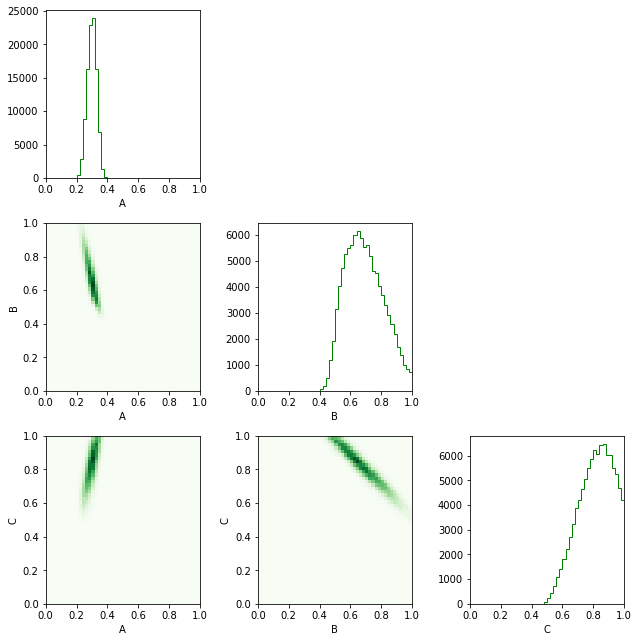

In [10]:
NDimension = len(AllData["labels"])
Ranges = np.array(AllData["ranges"]).T
figure, axes = plt.subplots(figsize = (3 * NDimension, 3 * NDimension), ncols = NDimension, nrows = NDimension)
Names = AllData["labels"]
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if i==j:
            ax.hist(MCMCSamples[:,i], bins=50,
                    range=Ranges[:,i], histtype='step', color='green')
            ax.set_xlabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
        if i>j:
            ax.hist2d(MCMCSamples[:, j], MCMCSamples[:, i], 
                      bins=50, range=[Ranges[:,j], Ranges[:,i]], 
                      cmap='Greens')
            ax.set_xlabel(Names[j])
            ax.set_ylabel(Names[i])
            ax.set_xlim(*Ranges[:,j])
            ax.set_ylim(*Ranges[:,i])
        if i<j:
            ax.axis('off')
plt.tight_layout(True)
plt.savefig('plots/Correlation.pdf', dpi = 192)
# figure

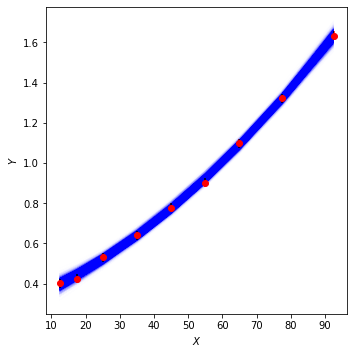

In [11]:
Examples = MCMCSamples[ np.random.choice(range(len(MCMCSamples)), 5000), :]

TempPrediction = {"PbPb5020": EmulatorPbPb5020.predict(Examples)}

figure, axes = plt.subplots(figsize = (5, 5), ncols = 1, nrows = 1)

axes.set_xlabel(r"$X$")
axes.set_ylabel(r"$Y$")
        
S1 = AllData["systems"][0]
O  = AllData["observables"][0][0]
S2 = AllData["observables"][0][1][0]

DX = AllData["data"][S1][O][S2]['x']
DY = AllData["data"][S1][O][S2]['y']
DE = np.sqrt(AllData["data"][S1][O][S2]['yerr']['stat'][:,0]**2 + AllData["data"][S1][O][S2]['yerr']['sys'][:,0]**2)
                
for i, y in enumerate(TempPrediction[S1][O][S2]):
    axes.plot(DX, y, 'b-', alpha=0.0025, label="Posterior" if i==0 else '')
axes.errorbar(DX, DY, yerr = DE, fmt='ro', label="Measurements")

plt.tight_layout(True)
figure.savefig('plots/ObservablePosterior.pdf', dpi = 192)
# figure

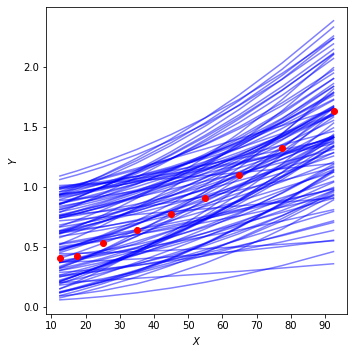

In [12]:
Examples = AllData["design"]

TempPrediction = {"PbPb5020": EmulatorPbPb5020.predict(Examples)}

figure, axes = plt.subplots(figsize = (5, 5), ncols = 1, nrows = 1)

axes.set_xlabel(r"$X$")
axes.set_ylabel(r"$Y$")
        
S1 = AllData["systems"][0]
O  = AllData["observables"][0][0]
S2 = AllData["observables"][0][1][0]

DX = AllData["data"][S1][O][S2]['x']
DY = AllData["data"][S1][O][S2]['y']
DE = np.sqrt(AllData["data"][S1][O][S2]['yerr']['stat'][:,0]**2 + AllData["data"][S1][O][S2]['yerr']['sys'][:,0]**2)
                
for i, y in enumerate(TempPrediction[S1][O][S2]):
    axes.plot(DX, y, 'b-', alpha=0.5, label="Posterior" if i==0 else '')
axes.errorbar(DX, DY, yerr = DE, fmt='ro', label="Measurements")

plt.tight_layout(True)
figure.savefig('plots/ObservablePrior.pdf', dpi = 192)
# figure

In [13]:
# close all plots to save memory
plt.close('all')